In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Lambda
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load the numpy array X from the compressed .npz file
X_train = np.load('/content/drive/MyDrive/X_train.npz')
X_test  = np.load('/content/drive/MyDrive/X_test.npz')

Y_train = np.load('/content/drive/MyDrive/Y_train.npz')
Y_test  = np.load('/content/drive/MyDrive/Y_test.npz')


X_train =X_train['X']
X_test  =X_test ['X']

Y_train =Y_train['X']
Y_test  =Y_test ['X']


ModuleNotFoundError: No module named 'google.colab'

In [14]:


shape = 64*64*3


def build_vae(input_shape, layer_neurons, latent_dim):
    # Input for the encoder
    inputs = tf.keras.Input(shape=(input_shape,))

    # Encoder architecture
    x = inputs
    for neurons in layer_neurons:
        x = layers.Dense(neurons, activation='relu', kernel_initializer='he_normal')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    # Reparameterization trick
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

    # Encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Input for the decoder
    decoder_inputs = tf.keras.Input(shape=(latent_dim,))

    # Decoder architecture
    x = decoder_inputs
    for neurons in reversed(layer_neurons):
        x = layers.Dense(neurons, activation='relu', kernel_initializer='he_normal')(x)
    outputs = layers.Dense(input_shape, activation='sigmoid')(x)

    # Decoder model
    decoder = Model(decoder_inputs, outputs, name='decoder')

    return encoder, decoder


# Instantiate the VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,

        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        '''cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=reconstructed, labels=inputs)
        reconstruction_loss = -tf.reduce_sum(cross_ent, axis=1)
        log2pi = tf.math.log(2. * np.pi)
        #normal pdf
        logpz = tf.reduce_sum(-0.5 * ((z - 0.) ** 2.), axis=1)
        logqz_x=tf.reduce_sum(-.5 * ((z - z_mean) ** 2. * tf.exp(-z_log_var) + z_log_var + log2pi),axis=1)
        kl_loss = logpz - logqz_x
        total_loss=-tf.reduce_mean(reconstruction_loss + 0.01* kl_loss)'''


        reconstruction_loss = tf.reduce_mean(  tf.keras.losses.binary_crossentropy(inputs, reconstructed)  )
        reconstruction_loss *= 1
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + 0.001*kl_loss

        self.add_loss(total_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)



        return reconstructed

#encoder , decoder = build_vae(shape)
#vae = VAE(encoder, decoder, name='vae')


# Compile the model
#vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
#X_train = X_train.reshape(-1, 64*64*3)
#X_test = X_test.reshape(-1, 64*64*3)

# Train the VAE
#history = vae.fit(X_train[0:12000], X_train[0:12000], epochs=3,validation_data=(X_test[0:1000], X_test[0:1000]) ,batch_size=32,verbose = 1)

In [17]:
#with crossvalidation tawel we mo2rf 5 sa3at leeeeeeeeeh
def cross_validate_autoencoder(X, hidden_layer_configs,latent_dim ,folds = 5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    input_shape = 64*64*3
    X = X.reshape(-1, 64*64*3)

    histories = {}   #save the history of each configuration training
    best_loss_ever = float('inf')  # Initialize the best loss
    best_AutoEncoder = None  # Placeholder for the best model
    best_Encoder = None
    best_Decoder = None

    for i, hidden_layers in enumerate(hidden_layer_configs):
        best_fold_history = None
        best_fold_loss=float('inf')
        print(f"Training with {hidden_layers} hidden layers")

        for k,(train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"Fold {k+1}/{folds}")
            X_train, X_val = X[train_idx], X[val_idx]
            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')

            # Build and compile the autoencoder
            encoder, decoder = build_vae(input_shape, hidden_layers ,latent_dim[i] )
            vae = VAE(encoder, decoder, name='vae')


            # Compile the model
            vae.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), metrics=['accuracy'])


            # Train the VAE
            history = vae.fit(X_train, X_train, epochs=20,validation_data=(X_val, X_val) ,batch_size=32,verbose = 1)

            # Evaluate on validation data
            loss = min(history.history['val_total_loss'])

            #target is to save the history for best crossvalidation
            if loss < best_fold_loss:
                best_fold_loss = loss
                best_fold_history = history  # Save the best fold's training history


            #save the model with best configuration
            if loss < best_loss_ever:
                best_loss_ever= loss
                best_AutoEncoder  = vae     # Save the current best model
                best_Encoder  = encoder
                best_Decoder  = decoder

        histories[str(hidden_layers)] = best_fold_history  # Store the history for the best fold

    return  histories ,best_AutoEncoder,best_Encoder,best_Decoder


In [18]:
from tensorflow.keras import layers

hidden_layer_configs = [
    [256],               # Single hidden layer with 256 neurons
    [512 ,256],
    [1024, 512],
    [1024 , 512 ,256],

]
latent_dim = [32,54,256,128]



# Perform cross-validation
histories,autoencoder,encoder,decoder= cross_validate_autoencoder(X_train, hidden_layer_configs,latent_dim)

Training with [256] hidden layers
Fold 1/5
Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - kl_loss: 87.4860 - reconstruction_loss: 8195.7090 - total_loss: 8195.7988 - val_kl_loss: 157.7289 - val_reconstruction_loss: 8038.6299 - val_total_loss: 8039.1035
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - kl_loss: 161.9700 - reconstruction_loss: 8033.3115 - total_loss: 8033.4731 - val_kl_loss: 175.9737 - val_reconstruction_loss: 8014.3350 - val_total_loss: 8014.7407
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 178.8279 - reconstruction_loss: 8012.5767 - total_loss: 8012.7534 - val_kl_loss: 185.8556 - val_reconstruction_loss: 8005.3677 - val_total_loss: 8005.7183
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 187.7897 - reconstruction_loss: 8005.4590 - total_loss: 8005.6475 - val_kl_loss: 191.0101 - val_reconstruction_loss: 8002.3623 - val_total_loss: 8002.7104
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 191.6482 - reconstruct

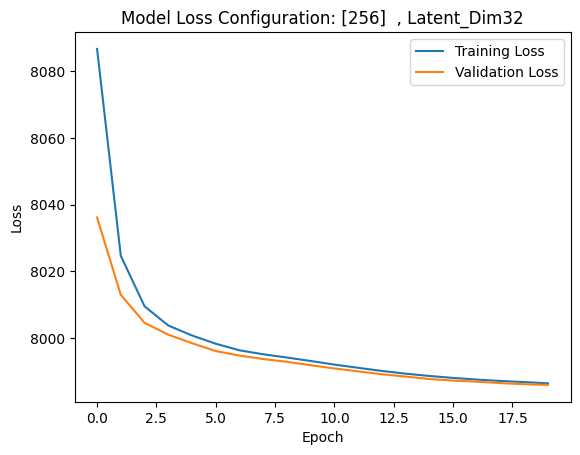

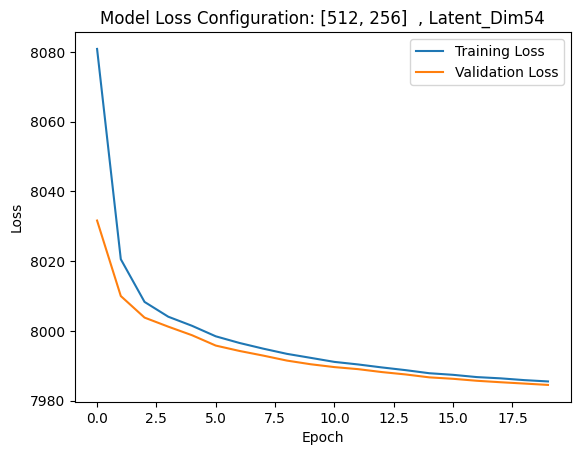

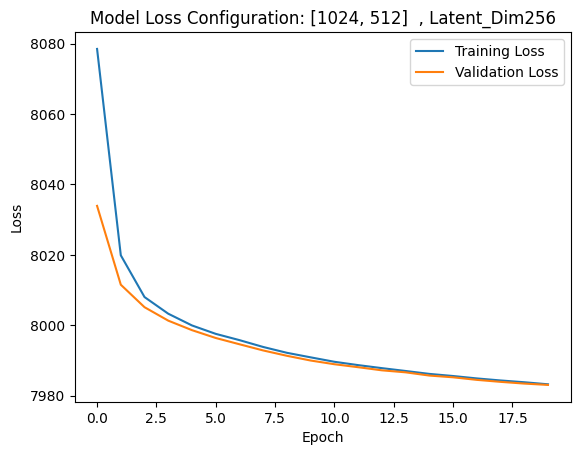

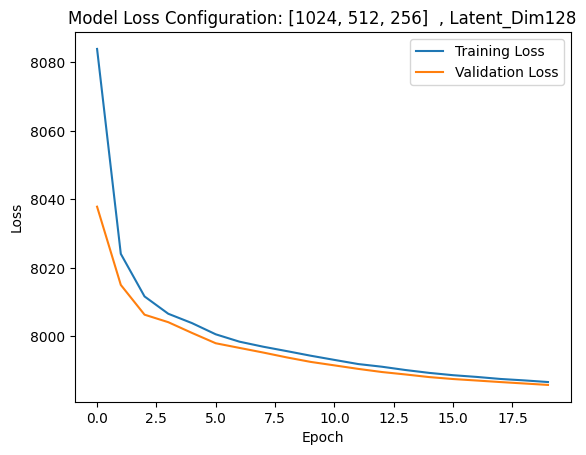

In [20]:
for i,_ in enumerate(hidden_layer_configs):
    key = list(histories.keys())[i]  # Get the second key in the dictionary
    history = histories[key]


    loss = history.history['total_loss']
    val_accuracy = history.history['val_total_loss']
    plt.plot(loss, label='Training Loss')
    plt.plot(val_accuracy, label='Validation Loss')
    plt.title(f"Model Loss Configuration: {key}  , Latent_Dim{latent_dim[i]}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [21]:
#Accuracy
def accuracy(y_test1, y_pred1):
    y_pred1 = np.array(y_pred1)
    counter = 0
    for i in range(len(y_pred1)):
      if (y_pred1[i] == y_test1[i]):
        counter += 1
    accuracy = counter / len(y_pred1)
    accuracy *= 100
    return accuracy

In [24]:
#ecludian distance classifer "NN"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

feature_vector_test = encoder.predict(X_test.reshape(-1,64*64*3))
feature_vector_train =encoder.predict(X_train.reshape(-1,64*64*3))



41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [27]:
print(feature_vector_test.shape)
print(feature_vector_train.shape)

(3, 1303, 256)
(3, 7381, 256)


In [30]:
feature_vector_test=np.array (feature_vector_test)
feature_vector_train=np.array(feature_vector_train)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(feature_vector_train[2], Y_train)#X_train.reshape(X_train.shape[0], -1)
predictions = knn.predict(feature_vector_test[2])
accuracy(Y_test, predictions)

16.039907904834998

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


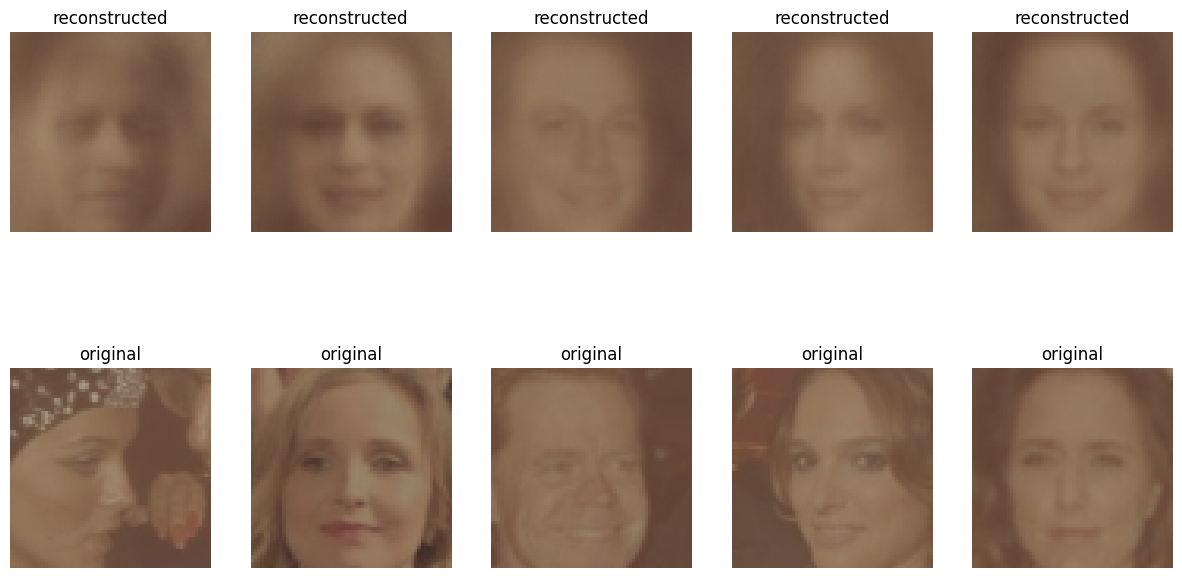

In [48]:
from matplotlib import pyplot as plt
SS = autoencoder.predict(X_test.reshape(-1,64*64*3))
plt.figure(figsize=(15, 8))
for i in range(5):
  plt.subplot(2, 5, i+1)
  plt.imshow(SS[i+200].reshape(64,64,3))
  plt.axis('off')
  plt.title(f"reconstructed")


  plt.subplot(2, 5,i+6)
  plt.imshow(X_test[i+200])
  plt.axis('off')
  plt.title(f"original")